# Social Computing/Social Gaming - Summer 2020

# Exercise Sheet 6 - Reality Mining

Reality mining is a field of data analysis with focus on the collection of real-world human data. This, for instance, includes movement, other environmental or social data retrieved from different kind of sensors. From the lecture you already know that in reality mining, social signal processing techniques like collecting social data from mobile phones are used. In this exercise, we will use the dataset and method presented in [1] in order to analyze how reality mined data can be used to uncover regular rules and structure in the behavior of individuals as well as infer relationships between them.

The dataset presented in [1] had been collected within the frame of the MIT university over a time span of nine months (from September 2004 to June 2005) and covers information from MIT staff and students. There were 106 participants that contributed to the data collection but not permanently. You will notice that not for every user at all times, sufficient data is present. The information collected is mostly retrieved from the user's phones, including **call logs, a device's location status, other Bluetooth devices in proximity, devices within the same cell tower range and surveys answered by the study's subjects**. The dataset consists of several components but you are given only the relevant ones which will be explained in-depth within context of the respective problem they will be used for. The aim of this exercise is to use the given data to analyze activity patterns based on a user's location and inferring community structure based on a user's proximity to others.

[1] N. Eagle, A. Pentland: _Reality Mining: Sensing Complex Social Systems._ Personal and Ubiquitous Computing, 10(4), 255-268, 2006. ([PDF](http://realitycommons.media.mit.edu/pdfs/realitymining_old.pdf))

## Imports & Reading The Data
First of all, we need to import a few modules and reading in the data in order for this exercise to work.

In [1]:
import scipy, random, pickle as pkl, numpy as np, pandas as pd, seaborn as sns, scipy as sc, networkx as nx, matplotlib as mpl, matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime, timedelta
from scipy.spatial import distance
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support


# Set paramters for plotting
width = 7
height = width / 1.618
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['figure.figsize'] = (width, height)

%matplotlib inline

# Reading in the pickle file
with open('Dataset.pkl', 'rb') as f:
    hourly_locs = pkl.load(f)
    feature_data = pkl.load(f)
    friends_set = pkl.load(f)
    not_friends_set = pkl.load(f)
    friends_survey = pkl.load(f)
    sbj_ids = pkl.load(f)

## Task 6.1: Activity Patterns

From the data we just read in, the data stored in the variable `hourly_locs` is needed for the current problem. It is a dictionary that contains the locations for each UUID (identifier for a subject's phone) at every hour of the day (0-23). Some subjects only participated in the study for a while, resulting in sparse data for some UUIDs. The locations are given as numbers:
* 0 – no signal
* 1 – at home
* 2 – at work
* 3 – elsewhere
* NaN – phone is off

Since the data collection's duration amounted to several months, **the analysis of the subjects' activity patterns is a desirable possibility**. The approach in [1] was to create a Hidden Markov Model in order to *predict where an individual may be located in the future. We will not compute such a model but we are interested in a precondition of it - the predictability*. **We want to find out whether the data would be suitable for prediction at all**. Therefore, some kind of measurement for information content needs to be used. A classical measure for that is Shannon's entropy given by the following equation:
$$H(x) = - \displaystyle\sum_{i=1}^{n}p(i)\log_2p(i)$$

where $n$ is the number of places and $p(i)$ the respective probability for the $i$-th location in our case.


### a) Entropy Calculation
**Compute the entropy values for all users for the whole duration of the study.** For this purpose, count the occurences of each location for every user and calculate a probabilty distribution of the places. Then implement the formula given above with the just calculated probabilities. As mentioned above, not all UUIDs from 0 to 106 are taken so you should work with an exception here in order to avoid key errors - assign an entropy of -1 if an UUID is missing. **Your program's output is supposed to be an entropy list, containing the values for each user**.

In [2]:
entropy_list = []

# Loop over all UUIDs
for uuid in range(107):
    try:
        # Calculate frequency for each location
        places_f = Counter([p for p_list in (hourly_locs[uuid][h] for h in range(24)) for p in p_list if not np.isnan(p)])
        
        # TODO: Calculate probability for each location
        total = sum(places_f.values())
        for place, occ in places_f.items():
            places_f[place] = occ / total
            
        # TODO: Compute entropy based on probabilities
        entropy = -sum(prob * np.log2(prob) for prob in places_f.values())
        
    # If UUID missing
    except:
        # TODO: Assign entropy -1
        entropy = -1
        
    entropy_list.append(entropy)
    
print('Entropy for each UUID:\n')
print('\t'.join([f'S{i}: {entropy:.4f}' for i, entropy in enumerate(entropy_list)]))

Entropy for each UUID:

S0: -1.0000	S1: 1.4056	S2: 0.7914	S3: 1.8855	S4: -1.0000	S5: -1.0000	S6: 0.4248	S7: 1.7254	S8: 1.6110	S9: 1.2118	S10: -1.0000	S11: -1.0000	S12: 1.7345	S13: 1.6931	S14: 1.5265	S15: 1.7665	S16: 1.6551	S17: -1.0000	S18: 1.1978	S19: 1.8717	S20: 1.9423	S21: 1.5851	S22: 1.8079	S23: -1.0000	S24: 1.7936	S25: 1.8885	S26: 1.4912	S27: -1.0000	S28: 0.9963	S29: 0.0000	S30: 1.7371	S31: -1.0000	S32: 1.3675	S33: 1.4682	S34: 1.8076	S35: 1.8237	S36: 1.7340	S37: 1.7751	S38: -1.0000	S39: 1.0058	S40: 1.4459	S41: 1.5389	S42: 1.4125	S43: -1.0000	S44: -1.0000	S45: -1.0000	S46: -1.0000	S47: -1.0000	S48: 1.0762	S49: 0.8827	S50: 1.5455	S51: 1.2730	S52: 1.8189	S53: 1.6072	S54: 1.6908	S55: 1.6649	S56: -1.0000	S57: -1.0000	S58: -1.0000	S59: 1.3166	S60: 1.6331	S61: 1.1653	S62: 0.7015	S63: -1.0000	S64: 0.2896	S65: -1.0000	S66: 1.2569	S67: -1.0000	S68: -1.0000	S69: 1.9110	S70: 1.4781	S71: 1.5927	S72: 1.5583	S73: 1.8528	S74: 1.5664	S75: 0.9832	S76: 1.5899	S77: 1.1498	S78: 1.2376	S79: -1.0000	S80

### b) Predicability of Activity Patterns
The next step is to compare the daily activities of two different subjects, one with a low entropy and one with a much higher entropy, and observe the differences in the regularity of their patterns. **Choose one subject with a low and another with a high entropy value, get their hourly locations for one month and create a heatmap for each. Describe the subjects' daily activites and the disparities between both subjects. Explain the resulting relationship between entropy and the predictability of an individual's activity patterns.** Do not write more than 5 sentences.<p>

**Notes:**
* Due to the lack of data for some users, their data might not be as insightful on certain months as for other subjects - choose accordingly.
* It is helpful to fill NaN values with -1.0 using pandas `fillna` function.

Entropy of S64: 0.2896303004925808


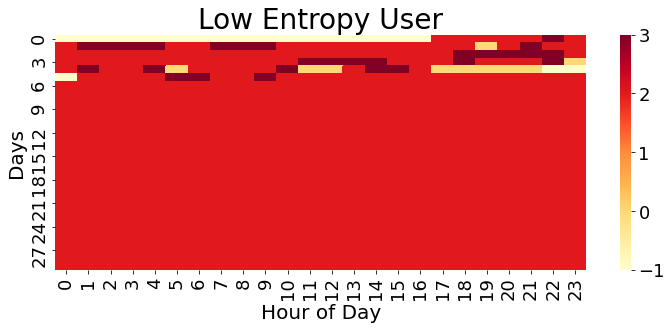

Entropy of S20: 1.9423388138823356


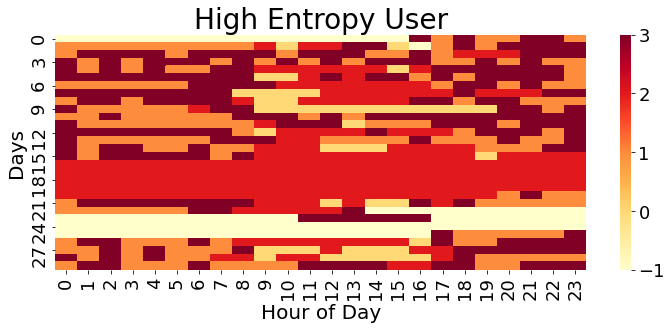

In [3]:
cbar = {"boundaries": np.linspace(-1.5, 3.5, 6)}
def decor_heatmap(ax):
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.linspace(-1, 3, 5))
    colorbar.set_ticklabels(['NaN/Phone Off', 'No Signal', 'At Home', 'At Work', 'Elsewhere'])

# TODO: Low entropy user
uuid = 64
# TODO: Get data for one month
data = pd.DataFrame(hourly_locs[uuid]).iloc[:,:30].transpose().fillna(-1)
print(f"Entropy of S{uuid}: {entropy_list[uuid]}")

# Create heatmap
cmap = mpl.cm.YlOrRd
fig, ax = plt.subplots(figsize=(1.7*width, height))
ax.set_title('Low Entropy User')
# ax = sns.heatmap(data, cmap=cmap, ax=ax, cbar_kws=cbar)
# decor_heatmap(ax)
ax = sns.heatmap(data, cmap=cmap, ax=ax)
ax.set(xlabel='Hour of Day', ylabel = 'Days')
plt.show()

# TODO: High entropy user
uuid = 20
# TODO: Get data for one month
data = pd.DataFrame(hourly_locs[uuid]).iloc[:, :30].transpose().fillna(-1)
print(f"Entropy of S{uuid}: {entropy_list[uuid]}")

# Create heatmap
cmap = mpl.cm.YlOrRd
fig, ax = plt.subplots(figsize=(1.7*width, height))
ax.set_title('High Entropy User')
# ax = sns.heatmap(data, cmap=cmap, ax=ax, cbar_kws=cbar)
# decor_heatmap(ax)
ax = sns.heatmap(data, cmap=cmap, ax=ax)
ax.set(xlabel='Hour of Day', ylabel = 'Days')
plt.show()

# 0 – no signal
# 1 – at home
# 2 – at work
# 3 – elsewhere
# NaN – phone is off

**TODO: Your observations here:**

- **Q**: *Describe the subjects' daily activites and the disparities between both subjects?*
- **A**: The low entropy user (S64) is most likely a Media Lab staff who resides in a dorm near the Lab because he only stayed at work almost all the time, regarless any hour of day and he was never at home during that month, therefore, we could claim that his daily activity was always the same, always working. On the other hand, the high entropy user (S20) has more randomness for his activities since his locations are much more scattered around the clock during that whole month and even at nights, he could be at home, at work or elsewhere. In summary, it is much harder to detect patterns in daily activities of a high entropy user, while the daily activity patterns of a low entropy user is more obvious and describeable.


- **Q**: *Explain the resulting relationship between entropy and the predictability of an individual's activity patterns?*
- **A**: The higher an entropy of an individual is, the less predictable their daily activities/routines/locations are, therefore, the more obscure their activity patterns are. This is because entropy is a measure of how chaotic or how random something is.

### c) Prediction Applications

After having discovered the predictability in the first place, one could compute an above mentioned model (e.g. with the help of an HMM as done in [1]) in order to infer the locations of one or more users. **Which applications do these prediction have, what could they be used for? Discuss their advantages and disadvantages.** Don't write more than 5 sentences.

**TODO: Your discussion here:**

**Q**: *Which applications do these prediction have, what could they be used for?*\
**A**: Location predictions could be used for: 
- inferring user's context, which can be useful for location-based marketing, traffic planning, travel recommendation,  availability management, whose applications could be energy-efficient home automation, anomaly detection in security systems, user interruptability (in Human-Computer Interaction), context-aware applications, personalization,  etc.
- relationship inferrence between individuals since knowledge of the shared context of two users can provide insight into the nature of their association, which can be of value for group recommender systems, analysis of organizational rhythms and behaviors etc.
    
    
**Q**: *Discuss their advantages and disadvantages?*\
**A**: Advantages of those applications could be: (1) helping increase revenues for businesses through location-based marketing, group recommender systems etc., (2) helping alleviate traffic congestion and improve urban governmental planning. On the other hand, they also have disadvantages such as (1) privacy issue since they become intrusive into users' lives by tracking their locations, therefore, those applications usually struggle to collect real world data. Moreover, (2) location data is typically raw data without semantic information, which makes it hard to infer personal purpose, and (3) location data from mobile devices is generally imprecise, which makes it hard to achieve good performance for applications that need precise and specific locations of users.

Reference: http://downloads.hindawi.com/journals/misy/2018/1852861.pdf


## Task 6.2: Inferring Friendship - Clustering

Now we want to continue our analysis with the `feature_data` variable read in at the beginning. The goal is to predict whether two people are friends or not using a clustering approach. For that purpose, six features will be used: `_Total proximity_`, `_Saturday night proximity_`, `_proximity with no signal_`, `_proximity at home_`, `_the total number of cell towers together_` and `_phone calls per day_`. The idea behind it is that the more often two subjects encountered or interacted in a certain way, the more likely they are to know each other better and having some sort of relation (depending on the kind of interaction). The features above seem to be good indicators of friendship since most people will e.g. be spending their weekends (Saturday nights) with friends.

The variable `feature_data` is a dictionary of pandas dataframes for each subject. Each of these dataframes has other subjects as rows, with the following columns (the values were averaged):
* `totalprox` - total encounters with other subjects (min/day)
* `satprox` – encounters with other subjects on a Saturday night (min/week)
* `nosignalprox` – time where other subjects did also not have a signal (min/day)
* `homeprox` – encounters with other subjects at home (min/week)
* `commoncell` – total number of common cell towers for two subjects
* `callevent` – number of phone calls per day from others for each user
* `isfriend` – 1 if the subject considers the other their friend, 0 if not

The last one matches with the variable `friends_survey` that is a dictionary of dicts for each subject, containing the information on who they consider friends. This was collected from actual surveys. The variable `sbj_ids` is a list of subject IDs (identifier for a surveyed person).

**Note**: As mentioned before, not for all subjects enough data was collected so there won't be an entry for those.


### Actual Friends Network
As part of the data collected by [1], subjects answered a survey in which they indicated who they considered close friends. Below, we use the networkx library to plot this network of friends in order to compare it with our predictions later.

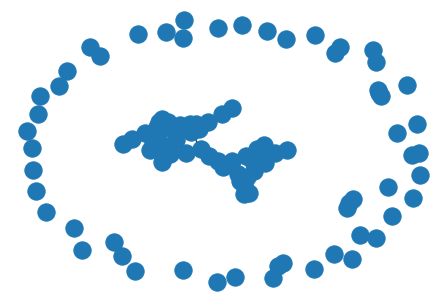

In [4]:
ids_len = len(sbj_ids)
friends_matrix = np.empty((ids_len, ids_len))

# Create adjacency matrix for surveyed friendships
for i, sid in enumerate(sbj_ids):
    friends_matrix[i] = [friends_survey[sid][sid2] for sid2 in sbj_ids]

# Delete self loops
np.fill_diagonal(friends_matrix, 0)
    
# Create graph from adjacency matrix
g = nx.from_numpy_matrix(friends_matrix)

nx.draw(g)

### Gaussian Mixture Models & Inferred Network
We will work with a Gaussian mixture model, you should already be familiar with GMMs from the lecture. It is a probabilistic model of several Gaussian distributions whose mixture generate all the data points with unknown parameters. The parameters for a GMM get trained using the **expectation-maximization** (EM) algorithm. You can think of it as generalized k-means clustering but instead of assigning one particular label to each point, each point belongs to each "cluster" with a certain probability. We will apply the clustering approach for each subject and predict their friendship with another person afterwards.


## Task 6.2: Inferring Friendship - Clustering

**1.** Since we have the actual friendship network available, the results can be compared with that network graphically. We are also interested in the accuracy, the proportion of correctly predicted friends. **First of all, complete the code by computing the accuracy. What does the outcome indicate? Compare the actual and the inferred friendship graph.** Don't write more than 3 sentences.

**2.** As a next step, you are supposed to deal with the [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) module. Change the number of compontents in the `GaussianMixture` class constructor to other values. **What reasoning does a GMM use to predict labels? How does the inferred graph change? Can you think of any implications for the distinction of friendships and are there other features suitable to get meaningful information?** Don't write more than 5 sentences.

**Note:** The problematic with predicting labels from a GMM is not knowing what label belongs to which component - we assume the most commonly predicted label is always 'not friends' which is more realistic.

Overall accuracy (k=1): 0.9875 +/- 0.0167


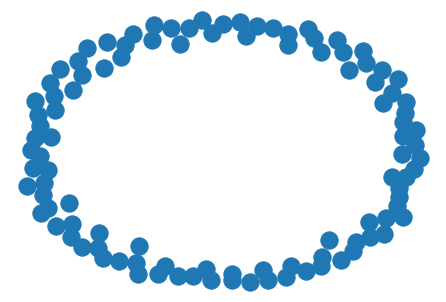

Overall accuracy (k=2): 0.8728 +/- 0.0976


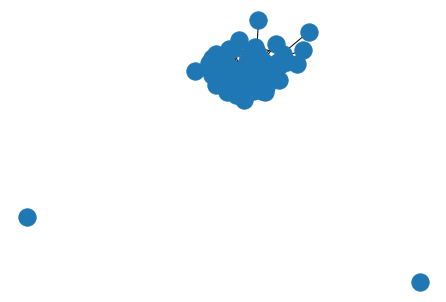

Overall accuracy (k=4): 0.7490 +/- 0.1355


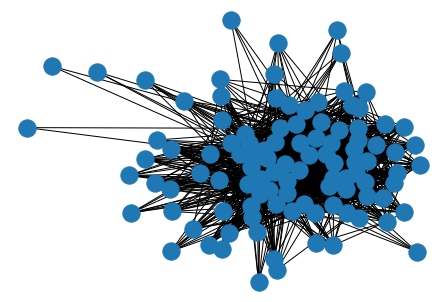

Overall accuracy (k=6): 0.6586 +/- 0.1522


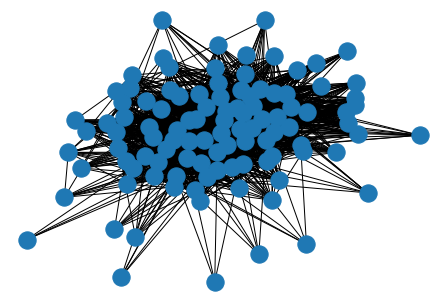

Overall accuracy (k=10): 0.5612 +/- 0.1274


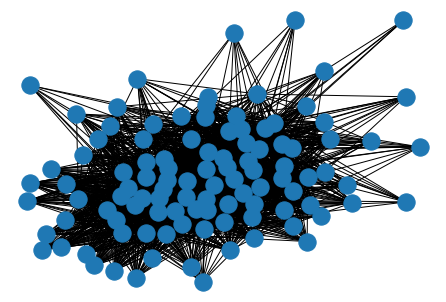

Overall accuracy (k=15): 0.4682 +/- 0.1450


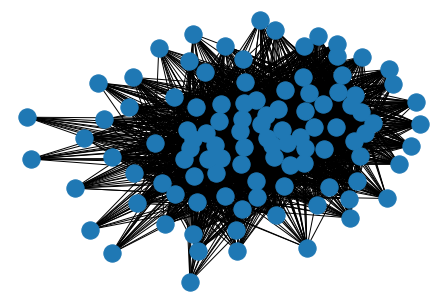

In [5]:
gmm_accuracy = dict()
predictions_dict = dict()
ids_len = len(sbj_ids)-1
gmm_friends_matrix = np.empty((ids_len, ids_len))

for k in [1, 2, 4, 6, 10, 15]:
    # Loop over all subject IDs
    for sid in list(feature_data.keys()):
        # Extract the features for current subject
        feature_table = feature_data[sid]
        x = feature_table.loc[:,:'callevent'].values

        # Fitting of the GMM to the features
        # TODO: Vary the number of components
        model = GaussianMixture(n_components=k, max_iter=500)
        model.fit(x)

        # Prediction of friendships between current subject and all others
        gmm_pred = model.predict(x)

        # Labels (0 or 1) are randomly assigned to 'friends' and 'not friends' but most common intuitively is the latter
        not_friend = Counter(gmm_pred).most_common()[0][0]

        # Create dict for predicted friendships
        predicted = pd.DataFrame({'subject': list(feature_table.index), 'isfriendP': [int(label != not_friend) for label in gmm_pred]}).set_index('subject')
        predictions_dict[sid] = predicted

        # Evaluate which predictions match the actual friendship
        acc = feature_table.assign(isfriendP = predicted['isfriendP']).pipe(lambda df: df.isfriend == df.isfriendP)

        # TODO: Compute accuracy
        gmm_accuracy[sid] = acc.values.sum() / len(acc)


    # Show accuracy for all users
    print('Overall accuracy (k={}): {:.4f} +/- {:.4f}'.format(k, pd.Series(gmm_accuracy).mean(), pd.Series(gmm_accuracy).std()))

    # Create inferred network (adjacency matrix)
    for i, sid in enumerate(sbj_ids):
        try:
            gmm_friends_matrix[i-1] = predictions_dict[sid].isfriendP.values
        except:
            gmm_friends_matrix[i-1] = [0] * ids_len

    # Delete self loops
    np.fill_diagonal(gmm_friends_matrix, 0)

    # Create graph from adjacency matrix
    g = nx.from_numpy_matrix(gmm_friends_matrix)

    nx.draw(g)
    plt.show()

**TODO: Your observations here:**

### 1)
- **Q**: _What does the outcome indicate? Compare the actual and the inferred friendship graph?_
- **A**: The overall accuracy (for $k=2$) is pretty high with $87\%$ correct predictions on average and the respective standard deviation is also acceptable with $10\%$. However, this high accuracy does not indicate that we can very well predict the actual friendships between the subjects because this is an extremely imbalanced dataset with class $0$ (not friend) being the highly predominant class. As a result, the inferred friendship graphs does not at all resemble the actual friendship and is much connected than the actual one with much less number of singleton nodes despite the high average accuracy achieved


### 2)
- **Q**: *What reasoning does a GMM use to predict labels?*
- **A**: For each sample $x$, GMM computes the $k$ responsibilities for $x$ based on the probability density function of each cluster's Gaussian distribution and assigns $x$ to the cluster that has the highest responsibility for $x$, where responsibility, according to the lecture, is a probability that $x$ belongs to a cluster and $k$ is the number of clusters. 

<!-- In this exercise, the labels $\in \{0, 1, ..., k \}$ are converted to $\{0, 1\}$, in which all predicted cluster numbers  -->


- **Q**: *How does the inferred graph change?*
- **A**: The inferred graph has more edges and becomes more connected as $k$ increases, which indicates there are more subjects becomes friends with one another.


- **Q**: *Can you think of any implications for the distinction of friendships and are there other features suitable to get meaningful information?*
- **A**: Being able to distinct friendships within large groups of people has implications for the field of computational epidemiology and may help build more accurate models of pathogen dissemination e.g. the current SARS-CoV-2 pandemic, as well as other more innocuous contagions, such as the flow of information. Other features suitable to get meaningful information about friendships could be 
    - the time of day and day of weeks of out-of-workplace proximity between people
    - total out-of-workplace proximities
    - locations of proximities (workplace, home, hang-out places, etc.)

## Task 6.3: Inferring Friendship with Generative Classification

Since the clustering approach with Gaussian mixture models only indicates who might be friends, the better option to analyze group affiliation is by using an actual classification approach. There are two classes, those who consider another person their friend (class 1) and those who do not (class 0). For that purpose, we need to built a **generative (Gaussian mixture) model** for each class and classify a new feature vector according to the probabilties these models return. The probabilty for class $c$ given the new vector $x$ and the parameters $\theta$ is:

$$p(y=c \mid x,\theta) \propto p(x \mid y=c, \theta) \cdot p(y=c \mid \theta)$$

where the first term is a **class-conditional density** and the second term a **class prior**. The vector will be assigned the classes' label with the highest probability. The $\propto$-operator means "proportional to" and comes from leaving out the scaling (see Bayes theorem).

The class priors are equivalent to the labels' relative frequencies. To get the class-conditional density, a Gaussian mixture model is fit to a suitbale amount of training data (our six-dimensional feature vectors). This is again done using the EM algorithm. The model yields the component's weights as well as the parameter vector $\theta$, containing each component's means and covariances. The class-conditional density for one class is given by:
$$p(x \mid \theta) = \sum_{k=1}^{K} \pi_{k} \mathcal{N}(x \mid \mu_{k}, \Sigma_{k})$$

where $K$ is the number of mixture components and $\pi_{k}$ the $k$-th component's weight. For more details, refer to the lecture on GMMs.

### Classifier Performance

After building a classifier, it is essential to evaluate how well it actually performs by comparing it with the existent ground truth. A common way to do this is using statistical measures for analysis, e.g. precision, recall or a combined method like the F1 score. They are defined as:

$$P = \frac{TP}{TP + FP}, \hspace{10mm} R = \frac{TP}{TP + FN}, \hspace{10mm}  F_1 = 2 \cdot \frac{P \cdot R}{P + R}$$

Each of these measures is applied **_per label_**. For the label 'friends' we call it a **true positive** (TP) if a pair was classified as friends when they were, and **false positive** (FP) if classified as friends when they are in fact not. **True/false negatives** (TN, FN) correspondingly refer to not being classified as friends when they were (not). Analogously to the label 'not friends'.

### The Task

For this task, we use the previously read in variables `friends_set` and `not_friends_set` which corresponds to the data in `feature_table` but as a preprocessed format for easier usage in the below classification. The first set contains the people that consider another person their friend and the respective feature values that were already used in Problem 6.2, accordingly for the second set.

**Complete the code in the `GMM_classify` according to the formula given above. Vary the number of components as well as the number of feature vectors for training and testing, and evaluate the resulting classifer using the statistical measures presented above. What is the intuitive meaning for them in our case?** Don't write more than 6 sentences.

**Notes:**
* It might be helpful to look at the class priors when performing different splits.
* The training set has only few entries with class 'friends' since most of the subjects had no affiliation with each other.
* In case of a trivial classifier (one that always assigns one class), the statistical methods won't work well (there will be a warning) so these cases shouldn't be taken into account.

In [7]:
# Calculate the class-conditonal density
def conditional_density(x, GMM):
    prob = 0
    
    # Sum over all mixture components
    for k in range(GMM.n_components):
        # Define the 6-dimensional normal distribution for one component using the GMM parameters
        func = multivariate_normal(mean=GMM.means_[k], cov=GMM.covariances_[k], allow_singular=True)
        
        # Evaluate the function at point x, multiply with component's weight
        prob += GMM.weights_[k] * func.pdf(x)
        
    return prob
    

# Classify the 6-dimensional point x by comparing both GMM evaluations
def GMM_classify(x, GMM_fr, GMM_not_fr, prior_fr, prior_not_fr):
    
    # TODO: Compute the conditional densities
    proba_friend = conditional_density(x, GMM_fr) * prior_fr
    proba_not_friend = conditional_density(x, GMM_not_fr) * prior_not_fr
    
    # TODO: Return the label with higher probability
    return 1 if proba_friend >= proba_not_friend else 0

# Split into training and test data by taking random samples the sets
# TODO: Vary the number of feature vectors
training_fr = list(random.sample(friends_set, 24))
training_not_fr = list(random.sample(not_friends_set, 48))
test = list(friends_set - set(training_fr)) + list(random.sample(set(not_friends_set - set(training_not_fr)), 22))


# training_fr = list(friends_set)[:23]
# training_not_fr = list(not_friends_set)[:34]
# test = list(friends_set - set(training_fr)) + list(set(not_friends_set - set(training_not_fr)))[:18]


# Compute the relative class frequencies (priors)
num_pairs = len(training_fr) + len(training_not_fr)
prior_fr = len(training_fr) / num_pairs
prior_not_fr = len(training_not_fr) / num_pairs

print(f'prior_not_fr={prior_not_fr}, prior_fr={prior_fr}\n')

for k in [1, 2, 4, 6, 12, 15, 20]:
    # Generate GMM for 'friends'
    x_fr = np.asarray([tup[0] for tup in training_fr])
    GMM_fr = GaussianMixture(n_components=k, max_iter=500).fit(x_fr)

    # Generate GMM for 'not friends'
    x_not_fr = np.asarray([tup[0] for tup in training_not_fr])
    GMM_not_fr = GaussianMixture(n_components=k, max_iter=500).fit(x_not_fr)

    estimates = []
    ground_truth = []

    for x in test:
        # Classify the pair x as friends (1) or no friends (0)
        label = GMM_classify(x[0], GMM_fr, GMM_not_fr, prior_fr, prior_not_fr)

        estimates.append(label)
        ground_truth.append(x[1])


    # Evaluating the classifier
    print(f'k={k}')
    print('True: ', ground_truth)
    print('Pred: ', estimates)

    
    performance = precision_recall_fscore_support(y_true=ground_truth, y_pred=estimates)
    print('\nPrecision:', performance[0])
    print('Recall:', performance[1])
    print('F1 score:', performance[2])
    print('\n\n')

prior_not_fr=0.6666666666666666, prior_fr=0.3333333333333333
k=1
True:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Pred:  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Precision: [0.95238095 0.83333333]
Recall: [0.90909091 0.90909091]
F1 score: [0.93023256 0.86956522]



k=2
True:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Pred:  [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Precision: [0.91304348 0.9       ]
Recall: [0.95454545 0.81818182]
F1 score: [0.93333333 0.85714286]



k=4
True:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Pred:  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]

Precision: [0.94117647 0.625     ]
Recall: [0.72727273 0.90909091]
F1 scor

**TODO: Your observations here!**

- **Q**: *What is the intuitive meaning for the statistical measures in our case?*
- **A**: Understanding that *false negatives (FN)* are instances of wrongly predicting "not friend" while those people are actually in the friend circle and *false positives (FP)* are instances of wrongly predicting "friend" while those people are not in the friend cirlce, we can interpret the above statistical measures in our case as follows:

    - **Precision** of class "friend" ($1$) indicates the degree of how good our model is at precisely detecting real friendship relations without mistakenly putting strangers (or non-friend people) into the friend circle among a group of friends and saying all of them are friends to one another. Likewise, **Precision** of class "non-friend" ($0$) suggests the degree of how precise our model is at detecting no relations between individuals without falsely classifying people having friends as lone wolves. 
    
    - **Recall**  of class "friend" ($1$) shows how good our mode is at not missing real friendship relations without wrongly taking people out of their friend circle and saying they are not friends. Similarly,  **Recall** of class "non-friend" ($0$) reports the degree of how sensitive our model is to incorrectly label lone wolves as the ones being within a friend circle.
    
    - **F1-score** is a harmonic mean between Precision and Recall that can be used in place of accuracy to reliably evaluate the performance of a model in case of imbalanced datasets. In our case, having a high F1-score for each label means our model has only few misclassifications and is good at recognizing pattern of being in a friend circle as well as pattern of not being friends to one another.